# Model23: 27 clusters

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from utils import load_buzz, select, write_result
from features import featurize, get_pos
from containers import Questions, Users, Categories
from nlp import extract_entities

## GMM

In [2]:
import pickle


questions = pickle.load(open('questions01.pkl', 'rb'))
users = pickle.load(open('users01.pkl', 'rb'))
categories = pickle.load(open('categories01.pkl', 'rb'))

In [3]:
from sklearn.preprocessing import normalize


X_pos_uid = users.select(['ave_pos_uid', 'acc_ratio_uid'])
X_pos_qid = questions.select(['ave_pos_qid', 'acc_ratio_qid', 'ne_nor_mean', 'ne_mean', 'ne_median'])
X_pos_uid = normalize(X_pos_uid, norm='l1')
X_pos_qid = normalize(X_pos_qid, norm='l1')

In [4]:
print(X_pos_qid[0])
print(X_pos_uid[0])

[ 0.37281988  0.0046272   0.00383057  0.29878473  0.31993763]
[ 0.98978868  0.01021132]


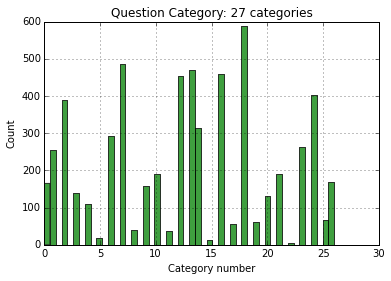

In [6]:
# Question category
n_components = 27
est = KMeans(n_clusters=n_components)
est.fit(X_pos_qid)
pred_cat_qid = est.predict(X_pos_qid)

plt.hist(pred_cat_qid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("Question Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

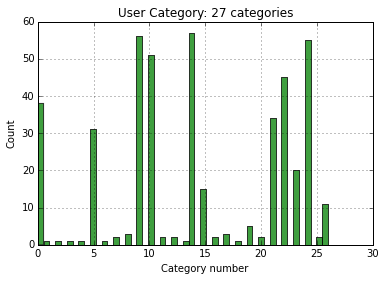

In [8]:
# User category
n_components = 27
est = KMeans(n_clusters=n_components)
est.fit(X_pos_uid)
pred_cat_uid = est.predict(X_pos_uid)

plt.hist(pred_cat_uid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("User Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

In [12]:
from collections import Counter


users.sub_append('cat_uid', {key: str(pred_cat_uid[i]) for i, key in enumerate(users.keys())})
questions.sub_append('cat_qid', {key: str(pred_cat_qid[i]) for i, key in enumerate(questions.keys())})

# to get most frequent cat for some test data which do not have ids in train set
most_pred_cat_uid = Counter(pred_cat_uid).most_common(1)[0][0]
most_pred_cat_qid = Counter(pred_cat_qid).most_common(1)[0][0]

print(most_pred_cat_uid)
print(most_pred_cat_qid)

14
18


## B. Modeling

In [13]:
def add_features(X):
    for item in X:
        # category
        for key in categories[item['category']].keys():
            item[key] = categories[item['category']][key]
            
        uid = int(item['uid'])
        qid = int(item['qid'])
        
        # uid
        if int(uid) in users:
            item.update(users[uid])
        else:
            acc = users.select(['acc_ratio_uid'])
            item['acc_ratio_uid'] = sum(acc) / float(len(acc))
            item['cat_uid'] = most_pred_cat_uid

        # qid
        if int(qid) in questions:
            item.update(questions[qid])

In [14]:
import pickle


questions = pickle.load(open('questions01.pkl', 'rb'))
users = pickle.load(open('users01.pkl', 'rb'))
categories = pickle.load(open('categories01.pkl', 'rb'))

In [15]:
from utils import load_buzz, select, write_result
from features import featurize, get_pos
from containers import Questions, Users, Categories
from nlp import extract_entities

import math
from collections import Counter

from numpy import abs, sqrt
from sklearn.linear_model import ElasticNetCV
from sklearn.cross_validation import ShuffleSplit, cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans


X_pos_uid = users.select(['ave_pos_uid', 'acc_ratio_uid'])
X_pos_qid = questions.select(['ave_pos_qid', 'acc_ratio_qid', 'ne_nor_mean', 'ne_mean', 'ne_median'])
X_pos_uid = normalize(X_pos_uid, norm='l1')
X_pos_qid = normalize(X_pos_qid, norm='l1')

tu = ('l1', 'n_uid_clust', 'n_qid_clust', 'rmse')
print ('=== Bench with ElasticNetCV: {0}, {1}, {2}, {3}'.format(*tu))
for ii in [27]:
    n_uid_clu = ii
    n_qid_clu = ii
    # clustering for uid
    uid_est = KMeans(n_clusters=n_uid_clu)
    uid_est.fit(X_pos_uid)
    pred_cat_uid = uid_est.predict(X_pos_uid)
    
    # clustering for qid
    qid_est = KMeans(n_clusters=n_qid_clu)
    qid_est.fit(X_pos_qid)
    pred_cat_qid = qid_est.predict(X_pos_qid)
    
    users.sub_append('cat_uid', {key: str(pred_cat_uid[i]) for i, key in enumerate(users.keys())})
    questions.sub_append('cat_qid', {key: str(pred_cat_qid[i]) for i, key in enumerate(questions.keys())})

    # to get most frequent cat for some test data which do not have ids in train set
    most_pred_cat_uid = Counter(pred_cat_uid).most_common(1)[0][0]
    most_pred_cat_qid = Counter(pred_cat_qid).most_common(1)[0][0]

    X_train, y_train = featurize(load_buzz(), group='train',
                                 sign_val=None, extra=['sign_val', 'avg_pos'])
    add_features(X_train)
    unwanted_features = ['ne_tags', 'pos_token', 'question', 'sign_val', 'group']
    wanted_features = list(set(X_train[1].keys()) - set(unwanted_features))
    X_train = select(X_train, wanted_features)

    vec = DictVectorizer()
    X_train_dict_vec = vec.fit_transform(X_train)
    X_new = X_train_dict_vec
    #X_new = LinearSVC(C=0.01, penalty="l1", dual=False, random_state=50).fit_transform(X_train_dict_vec, y_train)
    n_samples = X_new.shape[0]
    cv = ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=50)
    print("L1-based feature selection:", X_train_dict_vec.shape, X_new.shape)
    for l1 in [0.7]:
        scores = cross_val_score(ElasticNetCV(n_jobs=3, normalize=True, l1_ratio = l1),
                                 X_new, y_train,
                                 cv=cv, scoring='mean_squared_error')
        rmse = sqrt(abs(scores)).mean()
        print ('{0}, {1}, {2}, {3}'.format(l1, n_uid_clu, n_qid_clu, rmse))

=== Bench with ElasticNetCV: l1, n_uid_clust, n_qid_clust, rmse
L1-based feature selection: (28494, 1101) (28494, 1101)
0.7, 27, 27, 75.20202483477922


### Training and testing model

In [16]:
X_test = featurize(load_buzz(), group='test', sign_val=None, extra=['avg_pos'])
add_features(X_test)
X_test = select(X_test, wanted_features)

WARN: no key pos_token
WARN: no key ne_tags
WARN: no key group
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key group
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key group
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key group
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key group
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key group
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key group
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key group
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key group
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key group
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key group
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key group
WA

In [17]:
X_train[1]

{'acc_ratio_cat': 0.7560975609756098,
 'acc_ratio_qid': 0.875,
 'acc_ratio_uid': 0.6465863453815262,
 'answer': 'thomas cole',
 'ave_pos_cat': 43.640185830429736,
 'ave_pos_qid': 70.5,
 'ave_pos_uid': 96.724899598393577,
 'avg_pos_qid': 51.0,
 'avg_pos_uid': 30.973895582329316,
 'cat_qid': '17',
 'cat_uid': '21',
 'category': 'Fine Arts',
 'ne_count': 12,
 'ne_mean': 56.5,
 'ne_median': 60.5,
 'ne_mod': 65,
 'ne_nor_mean': 0.7243589743589743,
 'q_length': 78,
 'qid': 1,
 'uid': 1}

In [18]:
X_test[1]

{'acc_ratio_cat': 0.65625,
 'acc_ratio_qid': 0.6428571428571429,
 'acc_ratio_uid': 0.6712328767123288,
 'answer': 'david hilbert',
 'ave_pos_cat': 18.712499999999999,
 'ave_pos_qid': 79.857142857142861,
 'ave_pos_uid': 98.863013698630141,
 'avg_pos_qid': 15.571428571428571,
 'avg_pos_uid': 36.31506849315068,
 'cat_qid': '0',
 'cat_uid': '21',
 'category': 'Mathematics',
 'ne_count': 9,
 'ne_mean': 85.11111111111111,
 'ne_median': 97.0,
 'ne_mod': 97,
 'ne_nor_mean': 0.8105820105820106,
 'q_length': 105,
 'qid': 9967,
 'uid': 131}

In [19]:
vec = DictVectorizer()
vec.fit(X_train + X_test)
X_train = vec.transform(X_train)
X_test = vec.transform(X_test)

In [21]:
for l1_ratio in [0.7, 0.71, 0.715, 0.72]:
    print('=== l1_ratio:', l1_ratio)
    regressor = ElasticNetCV(n_jobs=3, normalize=True, l1_ratio=l1_ratio, random_state=50)
    regressor.fit(X_train, y_train)
    print(regressor.coef_)
    print(regressor.alpha_)
    predictions = regressor.predict(X_test)
    write_result(load_buzz()['test'], predictions, file_name=str(l1_ratio)+'guess_adj.csv', adj=True)

=== l1_ratio: 0.7
[  1.56230619e+01   2.88921130e+01   2.33607171e+01 ...,   2.90495858e-02
   4.23172874e-06  -2.69678564e-03]
0.000404215283508
** Adjust results ***
** tid qid uid: pred_pos, q_length, diff
32193 123840 15 : 34.91780291573168 , 33 , 1.9178029157316772
32186 123840 28 : 36.24640522200152 , 33 , 3.2464052220015205
32081 123757 1 : 33.571051043199354 , 29 , 4.571051043199354
32067 123750 43 : 26.0677140241362 , 19 , 7.067714024136201
32025 123718 39 : 18.419647707761506 , 13 , 5.419647707761506
32018 123718 13 : 21.270815027851704 , 13 , 8.270815027851704
31997 123709 52 : 29.446784536671977 , 17 , 12.446784536671977
13083 106213 9 : 36.775664550967726 , 21 , 15.775664550967726
1232 674 161 : 48.238888782725915 , 48 , 0.2388887827259154
24990 106373 62 : 32.882267622933746 , 23 , 9.882267622933746

** diff_tot 68.83704143398133
=== l1_ratio: 0.71
[  1.56479507e+01   2.97106172e+01   2.39427841e+01 ...,   2.96101842e-02
   4.21321547e-06  -2.62326472e-03]
0.0003985221105